# Train Model to Detect Drownsiness with CNN

In [1]:
import os #cho phép làm việc với các tập tin/thư mục operated system
from keras.preprocessing import image
import matplotlib.pyplot as plt 
import numpy as np
from keras.utils.np_utils import to_categorical #chuyển đổi vecto đầu vào thành ma trận dữ liệu phân loại
import random,shutil #shutil cho phép xóa hoặc sao chép tập tin
from keras.models import Sequential 
from keras.layers import Dropout,Conv2D,Flatten,Dense, MaxPooling2D, BatchNormalization
from keras.models import load_model

In [2]:
def generator(dir, gen=image.ImageDataGenerator(rescale=1./255), shuffle=True,batch_size=1,target_size=(24,24),class_mode='categorical' ):
    return gen.flow_from_directory(dir,batch_size=batch_size,shuffle=shuffle,color_mode='grayscale',class_mode=class_mode,target_size=target_size)


In [3]:
BS= 32
TS=(24,24)
train_batch= generator('C:/Users/Admin/Downloads/dataset_new/train',shuffle=True, batch_size=BS, target_size=TS)
valid_batch= generator('C:/Users/Admin/Downloads/dataset_new/valid',shuffle=True, batch_size=BS, target_size=TS)
SPE= len(train_batch.classes)//BS
VS = len(valid_batch.classes)//BS
print(SPE,VS)

Found 2467 images belonging to 4 classes.
Found 433 images belonging to 4 classes.
77 13


In [4]:
img,labels= next(train_batch)
print(img.shape)

(32, 24, 24, 1)


In [6]:
model = Sequential([
    Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(24,24,1)),
    Conv2D(32,(3,3),activation='relu'),
#32 convolution filters used each of size 3x3
#again
    Conv2D(64, (3, 3), activation='relu'),

#64 convolution filters used each of size 3x3
#choose the best features via pooling
    
#randomly turn neurons on and off to improve convergence
    Dropout(0.25),
#flatten since too many dimensions, we only want a classification output
    Flatten(),
#fully connected to get all relevant data
    Dense(128, activation='relu'),
#one more dropout for convergence' sake :) 
    Dropout(0.5),
#output a softmax to squash the matrix into output probabilities
    Dense(4, activation='softmax')
])

model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 22, 22, 32)        320       
                                                                 
 conv2d_4 (Conv2D)           (None, 20, 20, 32)        9248      
                                                                 
 conv2d_5 (Conv2D)           (None, 18, 18, 64)        18496     
                                                                 
 dropout_2 (Dropout)         (None, 18, 18, 64)        0         
                                                                 
 flatten_1 (Flatten)         (None, 20736)             0         
                                                                 
 dense_2 (Dense)             (None, 128)               2654336   
                                                                 
 dropout_3 (Dropout)         (None, 128)              

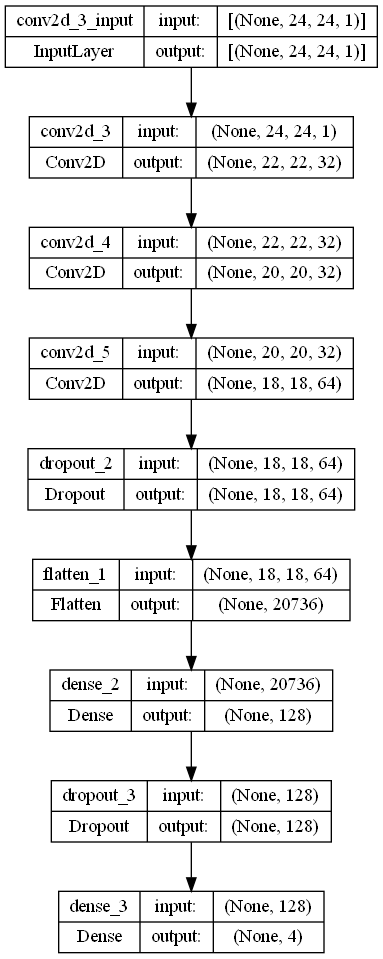

In [7]:
from keras.utils import plot_model
plot_model(model, show_shapes=True)

In [8]:
model.fit(train_batch, validation_data=valid_batch, batch_size=32, epochs=15, steps_per_epoch=SPE ,validation_steps=VS)
# để xem epoch 1 epoch 2... là như thế nào thôi, chứa dữ liệu mà model đã train
model.save('models/cnnCat2.h5', overwrite=True)

Epoch 1/15
77/77 [==============================] - 38s 452ms/step - loss: 0.7044 - accuracy: 0.6768 - val_loss: 0.4446 - val_accuracy: 0.7909
Epoch 2/15
77/77 [==============================] - 31s 401ms/step - loss: 0.4159 - accuracy: 0.7934 - val_loss: 0.3569 - val_accuracy: 0.8173
Epoch 3/15
77/77 [==============================] - 30s 391ms/step - loss: 0.3592 - accuracy: 0.8242 - val_loss: 0.3229 - val_accuracy: 0.8438
Epoch 4/15
77/77 [==============================] - 30s 395ms/step - loss: 0.3144 - accuracy: 0.8493 - val_loss: 0.3559 - val_accuracy: 0.8149
Epoch 5/15
77/77 [==============================] - 31s 405ms/step - loss: 0.3017 - accuracy: 0.8587 - val_loss: 0.2961 - val_accuracy: 0.8606
Epoch 6/15
77/77 [==============================] - 31s 400ms/step - loss: 0.2457 - accuracy: 0.8903 - val_loss: 0.2753 - val_accuracy: 0.8534
Epoch 7/15
77/77 [==============================] - 31s 404ms/step - loss: 0.2244 - accuracy: 0.9018 - val_loss: 0.2737 - val_accuracy: 0.8774

# Detect Drownsiness

In [32]:
import cv2 #làm việc với hình ảnh
import os #cho phép làm việc với các tập tin/thư mục
from keras.models import load_model
import numpy as np
from pygame import mixer #for loading and playing sounds
import time

In [33]:
mixer.init()
sound = mixer.Sound('alarm_out.wav')

In [34]:
face = cv2.CascadeClassifier('C:/Users/Admin/Downloads/Drowsiness detection/haar cascade files/haarcascade_frontalface_alt.xml')
leye = cv2.CascadeClassifier('C:/Users/Admin/Downloads/Drowsiness detection/haar cascade files/haarcascade_lefteye_2splits.xml')
reye = cv2.CascadeClassifier('C:/Users/Admin/Downloads/Drowsiness detection/haar cascade files/haarcascade_righteye_2splits.xml')

In [35]:
lbl=['Close','Open']

model = load_model('C:/Users/Admin/Downloads/Drowsiness detection/models/cnnCat2.h5')
path = os.getcwd()
cap = cv2.VideoCapture(0)
font = cv2.FONT_HERSHEY_COMPLEX_SMALL
score=0
thicc=2
rpred=[99]
lpred=[99]

In [36]:
while(True):
    ret, frame = cap.read() 
    height,width = frame.shape[:2]

    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    
    faces = face.detectMultiScale(gray,minNeighbors=5,scaleFactor=1.1,minSize=(25,25))
    left_eye = leye.detectMultiScale(gray)
    right_eye =  reye.detectMultiScale(gray)

    cv2.rectangle(frame, (0,height-50) , (200,height) , (0,0,0) , thickness=cv2.FILLED )
    # represents the top left corner and the bottom right corner of rectangle

    for (x,y,w,h) in faces:
        cv2.rectangle(frame, (x,y) , (x+w,y+h) , (100,100,100) , 1 )

    for (x,y,w,h) in right_eye:
        r_eye=frame[y:y+h,x:x+w]
        r_eye = cv2.cvtColor(r_eye,cv2.COLOR_BGR2GRAY)
        r_eye = cv2.resize(r_eye,(24,24)) 
        r_eye= r_eye/255 #Normalize để hội tụ tốt hơn (0-1)
        r_eye=  r_eye.reshape(24,24,-1)
        r_eye = np.expand_dims(r_eye,axis=0)
        rpred = np.argmax(model.predict(r_eye), axis=-1)
        if(rpred[0]==1):
            lbl='Open' 
        if(rpred[0]==0):
            lbl='Closed'
        break

    for (x,y,w,h) in left_eye:
        l_eye=frame[y:y+h,x:x+w]
        l_eye = cv2.cvtColor(l_eye,cv2.COLOR_BGR2GRAY)  
        l_eye = cv2.resize(l_eye,(24,24))
        l_eye= l_eye/255
        l_eye=l_eye.reshape(24,24,-1)
        l_eye = np.expand_dims(l_eye,axis=0)
        lpred = np.argmax(model.predict(l_eye), axis=-1)
        if(lpred[0]==1):
            lbl='Open'   
        if(lpred[0]==0):
            lbl='Closed'
        break

    if(rpred[0]==0 and lpred[0]==0):
        score=score+1
        cv2.putText(frame,"Closed",(10,height-20), font, 1,(255,255,255),1,cv2.LINE_AA)
    # if(rpred[0]==1 or lpred[0]==1):
    else:
        score=score-10
        cv2.putText(frame,"Open",(10,height-20), font, 1,(255,255,255),1,cv2.LINE_AA)
    
        
    if(score<0):
        score=0   
    cv2.putText(frame,'Score:'+str(score),(100,height-20), font, 1,(255,255,255),1,cv2.LINE_AA)
    if(score>15):
        #person is feeling sleepy so we beep the alarm
        cv2.imwrite(os.path.join(path,'image.jpg'),frame)
        try:
            sound.play()
            
        except:  #isplaying = False
            pass
        if(thicc<16):
            thicc= thicc+2
        else:
            thicc=thicc-2
            if(thicc<2):
                thicc=2
        cv2.rectangle(frame,(0,0),(width,height),(0,0,255),thicc) 
    cv2.imshow('frame',frame)
    if(score>=50):
        score=50
    cv2.putText(frame,'Score:'+str(score),(100,height-20), font, 1, (255,255,255),1, cv2.LINE_AA)
    #fontscale & thichness
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
    #cv2.waitKey() returns a 32 Bit integer value (might be dependent on the platform). 
    #The key input is in ASCII which is an 8 Bit integer value. 
    #So you only care about these 8 bits and want all other bits to be 0. 
cap.release()
cv2.destroyAllWindows()

1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 28ms/step


In [49]:
lpred=model.predict(l_eye)
lpred[0]

1/1 [==============================] - 0s 24ms/step


array([9.9981266e-01, 1.8739801e-04], dtype=float32)

In [59]:
lpred=np.argmax(model.predict(l_eye), axis=-1)
lpred[0]

1/1 [==============================] - 0s 25ms/step


0

In [41]:
np.argmax(model.predict(r_eye), axis=-1)

1/1 [==============================] - 0s 23ms/step


array([0], dtype=int64)

In [39]:
max(model.predict(r_eye))

1/1 [==============================] - 0s 22ms/step


array([9.9997807e-01, 2.1969721e-05], dtype=float32)

In [60]:
a=[[1,2,3,4,5,9,8,7,6]]
max_idx=np.argmax(a)
max_idx

5

In [15]:
model.predict(r_eye)

1/1 [==============================] - 0s 95ms/step


array([[0.80552185, 0.19447811]], dtype=float32)

In [18]:
a = [1]
a

[1]

In [21]:
a[0]=2
a

[2]